# Introduction

The purpose of this notebook is to provide code and instruction on using machine learning to improve the sensitivity of an analysis. The material presented here is taken largely from the [Top machine learning tutorial](https://topcptoolkit.docs.cern.ch/settings/met/), which covers additional material not covered here. The Jupyter notebook and associated code can be found at [analysis_demo](https://gitlab.cern.ch/jolamber/analysis_demo).

Since there are many great tutorials, books, videos, etc. that cover how to train a neural network, this demo will focus on aspects that are unique to performing machine learning in high energy physics.

# Scenario

An analysis is studying the $ttZ$ process. We assume here that the only major background to this process is $WZ$. To improve the sensitivity of the  analysis, a machine learning model is trained to separate signal and background.

# Steps that will be taken

- setting up the environment
- loading data from root files
- apply event selection
- flatten the data 
- use processed data to train a neural net using tensorflow
- evaluate the model performance

# Setting up the enviroment

For this demo, we will work on lxplus and perform the analysis in a continer that provides the packages needed to prepare the data and train a NN.

When loging into lxplus,
```
<user name>@lxplusXXX
```
note the value for `XXX` in the terminal when you login as we will need this later.

## Get files 

Clone the repository
```
git clone ssh://git@gitlab.cern.ch:7999/jolamber/analysis_demo.git
cd analysis_demo
```

Copy data files from eos
```
cp -r /eos/home-k/kzoch/top-ml-tutorial/data data
```

The environment that this notebook runs in is provided in a container available on eos. A container is a standalone package of software that includes everything needed to run an application including code and the environment that code will run in.

The container image can be obtained by running 
```
export SINGULARITY_CACHEDIR="/tmp/$(whoami)/singularity"                        
mkdir -p $SINGULARITY_CACHEDIR
singularity pull docker://gitlab-registry.cern.ch/jolamber/analysis_demo/docker/training:latest
```
The first command tells singularity to download cached data in the `tmp` directory instead of in your home directory. The second command will pull the docker container from the gitlab repository and convert this to a singularity container. This can take a long time to complete and you will need to make sure you have enough space available to download the container.

The container can also be downloaded from [CERNbox](https://cernbox.cern.ch/s/uP46gemxf20ti74).

## Jupyter notebook

Run the singularity container:
```
singularity run training_latest.sif
```
This will also start the Jupyter server in your home directory. You will need to make sure you put the git repository here so that it can be accessed from the Jupyter notebook. In order to connect to the Jupyter server from the browser on your computer you will need to open a new terminal and setup port forwarding
```
ssh -NL 8888:localhost:8888 <user name>@lxplusXXX.cern.ch
```
Note that `XXX` should correspond to the lxplus instance you are using. This can be found by looking at your propt on lxplus.

Open the Jupyter notebook in your browser using the link provided after strating the Jupyter server. 

Navigate to the git repository and open
```
analysis_ml_demo.ipynb
```
to open this notebook.

# Loading the data

For this demo, we will use the `uproot` package to load the data from root into `awkward` arrays.

In [1]:
# packages to read root files
import awkward as ak
import numpy as np
import uproot

For simplicity and to save time, we will only use one sample for signal and one for background.

In [2]:
data_dir = "data"
signal_file_path = f"{data_dir}/504329.aMCH7EG_NNPDF30NLO_H721UE_ttee.mc16a.root"
background_file_path = f"{data_dir}/364253.Sherpa_222_NNPDF30NNLO_lllv.mc16a.root"

## Inspecting the available trees

The root files contain two trees: the `sumWeights` trees contains information needed for lumi weighting and will not be used here. The `nominal` tree contains the branches that will be later used to train our model.

In [3]:
with uproot.open(signal_file_path) as file:
    for k in file.keys():
        print(k)

sumWeights;1
nominal;1


Similarly, we can access the contents of a particular tree and view the branches.

In [4]:
with uproot.open(signal_file_path) as file:
    nominal_tree = file["nominal"]
    for k in nominal_tree.keys():
        print(k)

weight_mc
eventNumber
runNumber
mcChannelNumber
mu
mu_actual
jet_pt
jet_eta
jet_phi
jet_e
jet_jvt
jet_truthflav
jet_truthPartonLabel
jet_isTrueHS
jet_truthflavExtended
jet_tagWeightBin_DL1r_Continuous
jet_DL1r
jet_DL1r_pb
jet_DL1r_pc
jet_DL1r_pu
met_met
met_phi
nPhotons
Leptons_Pt
Leptons_Eta
Leptons_Phi
Leptons_E
Leptons_Pdgid
Leptons_Charge
Leptons_Origin
Leptons_Type
Leptons_Istight_forReprocessing
Leptons_PdgOrigin
ElectronID_MediumLH
Leptons_Isol_PLVLoose
g2vSM_weight
g2vSM_top_v_pt
g2vSM_top_v_eta
g2vSM_top_v_phi
g2vSM_top_b_i
g2vSM_antitop_v_pt
g2vSM_antitop_v_eta
g2vSM_antitop_v_phi
g2vSM_antitop_b_i
jet_charge
jet_nTracks
jet_vtx_charge
Leptons_IFFclass


## Loading the data

We load variables related to jets, leptons, flavour tagging, and met.

After applying event selection, we will visualize the data.

In [5]:
signal_tree = uproot.concatenate(
    f"{signal_file_path}:nominal",
    [
        "jet_pt",
        "jet_eta",
        "jet_tagWeightBin_DL1r_Continuous",
        "Leptons_Pt",
        "Leptons_Eta",
        "met_met",

    ]
)

In [6]:
for f in ak.fields(signal_tree):
    print(f)

jet_pt
jet_eta
jet_tagWeightBin_DL1r_Continuous
Leptons_Pt
Leptons_Eta
met_met


## Awkward arrays

To get an idea of what an awkward array is, we can print out a the `jet_pt` branch for a few events.

In [7]:
print(type(signal_tree[0]["jet_pt"]))
print(signal_tree[0]["jet_pt"])
print(signal_tree[5]["jet_pt"])
print(signal_tree[10]["jet_pt"])

<class 'awkward.highlevel.Array'>
[7.66e+04, 6.92e+04, 5.99e+04, 5.52e+04, 3.16e+04]
[1.48e+05, 1.09e+05, 4.8e+04]
[1.75e+05, 5.8e+04, 5.35e+04, 3.97e+04, 3.74e+04, 2.76e+04]


We see that the number of jets in each event is different for each event. Before we can train a NN, the data will need to be transformed to a square array.

In [8]:
# number of jets...
print(len(signal_tree[0]["jet_pt"]))
print(len(signal_tree[5]["jet_pt"]))
print(len(signal_tree[10]["jet_pt"]))

5
3
6


In [9]:
background_tree = uproot.concatenate(
    f"{background_file_path}:nominal",
    [
        "jet_pt",
        "jet_eta",
        "jet_tagWeightBin_DL1r_Continuous",
        "Leptons_Pt",
        "Leptons_Eta",
        "met_met",

    ]
)

# Event selection

We can define a simple set of cuts to define a simple signal region that is enriched in $ttZ$ events. For this demo, the cuts are
- 3 or more jets
- exactly 3 lepton
- at least on b-jet

These cuts are encapsulated in a function that will return `True` if an event passes the simple selection requirements. 

For a real analysis, the cuts would be more complex.

In [10]:
def passes_selection(event):
    """Selects events with >=3 jets, ==3 leptons and >=1 b-jets (77%)."""
    if not len(event["jet_pt"]) >= 3:
        return False

    if not len(event["Leptons_Pt"]) == 3:
        return False

    if not ak.sum(event["jet_tagWeightBin_DL1r_Continuous"] >= 2) >= 1:
        return False

    return True

In [11]:
passes_selection(signal_tree[0])

True

Using the function above, we can create a mask to select events that pass the selection reuirements.

In [12]:
signal_sel_events = signal_tree[np.array(list(map(passes_selection, signal_tree)))]

In [13]:
background_sel_events = background_tree[np.array(list(map(passes_selection, background_tree)))]

## Inspecting the input variables 

It is a good idea to plot the distributions of the variables used to train a machine learning model to make sure there are no obvious problems. Here we plot a few distributions. To help estimate the ability of a variable to separate signal and background, the plots are normalized.

In [14]:
from plotting.plotting import create_plot
%matplotlib inline 

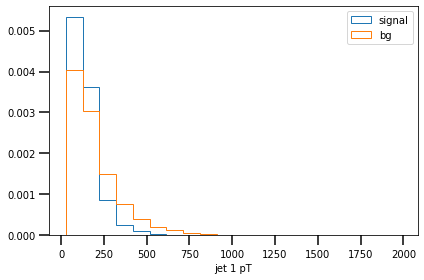

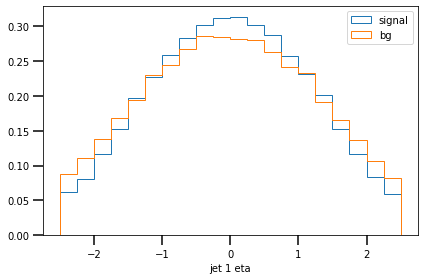

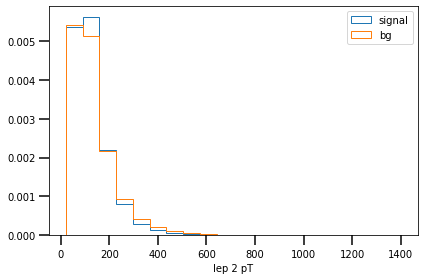

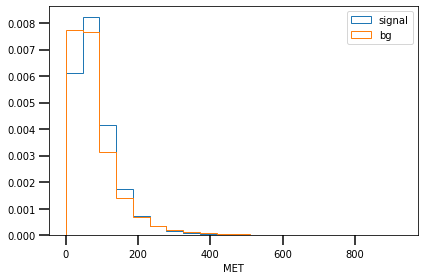

In [15]:
create_plot(signal_sel_events['jet_pt'][:,0] / 1e3, background_sel_events['jet_pt'][:,0] / 1e3, name="jet 1 pT")
create_plot(signal_sel_events['jet_eta'][:,0], background_sel_events['jet_eta'][:,0], name="jet 1 eta")
create_plot(signal_sel_events['Leptons_Pt'][:,0], background_sel_events['Leptons_Pt'][:,0], name="lep 2 pT")
create_plot(signal_sel_events['met_met'] / 1e3, background_sel_events['met_met'] / 1e3, name="MET")

## Flattening the data set

As mention previously, before the data can be used to train a simple NN, it must first be turned into a square array where the columns represent branches and the rows represent events. In the next demo, Alex will discuss NNs that can use length variable inputs. 

To flatten an event, we define a function that maps a column to a particular branch. These columns are
- jet 1 $p_T$
- jet 2 $p_T$
- jet 3 $p_T$
- jet 1 $eta$
- jet 2 $eta$
- jet 3 $eta$
- jet 1 continious b-tag score
- jet 2 continious b-tag score
- jet 3 continious b-tag score
- b-jet 1 $p_T$
- lepton 1 $p_T$
- lepton 2 $p_T$
- lepton 3 $p_T$
- number of jets
- number of b-jets
- met
- $H_T$

In [16]:
def get_flattened_event(event):
    """Flattens an event."""
    flattened_event = np.zeros(17, "f4")

    jet_pts = event["jet_pt"] / 1e3
    jet_etas = event["jet_eta"]
    jet_twbs = event["jet_tagWeightBin_DL1r_Continuous"]
    bjet_pts = jet_pts[jet_twbs > 1]
    lep_pts = event["Leptons_Pt"]
    met = event["met_met"] / 1e3
    h_t = ak.sum(ak.concatenate((jet_pts, lep_pts, met)))

    # jet pt
    flattened_event[0] = jet_pts[0]
    flattened_event[1] = jet_pts[1]
    flattened_event[2] = jet_pts[2]
    # jet eta
    flattened_event[3] = jet_etas[0]
    flattened_event[4] = jet_etas[1]
    flattened_event[5] = jet_etas[2]
    # jet btag 
    flattened_event[6] = jet_twbs[0]
    flattened_event[7] = jet_twbs[1]
    flattened_event[8] = jet_twbs[2]
    # bjet pt
    flattened_event[9] = bjet_pts[0]
    # lepton pt
    flattened_event[10] = lep_pts[0]
    flattened_event[11] = lep_pts[1]
    flattened_event[12] = lep_pts[2]
    # number of jets
    flattened_event[13] = len(jet_pts)
    # number of bjets
    flattened_event[14] = len(bjet_pts)
    # met
    flattened_event[15] = met
    # Ht
    flattened_event[16] = h_t

    return flattened_event


The function provided above is then applied to each selected event in the data set. Looking at the shape, we can see that the data set is now a square array where the number of columns correspond to the variables defined in our flattening function and the rows represent events.

In [17]:
signal_flattened_events = np.array(list(map(get_flattened_event, signal_sel_events)))

In [18]:
signal_flattened_events.shape

(133961, 17)

In [19]:
background_flattened_events = np.array(list(map(get_flattened_event, background_sel_events)))

In [20]:
background_flattened_events.shape

(47164, 17)

# Prepare data for training

Inorder for the model to trained, we need to tell it what events are signal (target value of `1`) and which are background (target value of `0`).

In [21]:
X = np.concatenate([signal_flattened_events, background_flattened_events])
y = np.concatenate(
    [
        np.ones(signal_flattened_events.shape[0], dtype=int),
        np.zeros(background_flattened_events.shape[0], dtype=int),
    ]
)

We split the the data set into three sets: 
- a training set (80%) that will be used to train the NN
- a validation set (10%) that will be used to evaluate the performance of the training while training
- and a test set (10%) to check to see how the model generalizes to data it has not seen before.

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
x_train, x_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8)
x_val, x_test, y_val, y_test = train_test_split(x_rem, y_rem, train_size=0.5)

## Defining the model

The NN is defined with three hidden layers and one output layer.

In [24]:
import tensorflow.keras as tf

In [25]:
preprocessing_layer = tf.layers.Normalization()
preprocessing_layer.adapt(x_train)

model = tf.Sequential(
    [
        preprocessing_layer,
        tf.layers.Dense(50, activation="relu", name="hidden1"),
        tf.layers.Dense(25, activation="relu", name="hidden2"),
        tf.layers.Dense(10, activation="relu", name="hidden3"),
        tf.layers.Dense(1, activation="sigmoid", name="output"),
    ]
)

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.0002),
    loss=tf.losses.BinaryCrossentropy(),
    metrics=[tf.metrics.BinaryAccuracy()],
)

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 17)               35        
 n)                                                              
                                                                 
 hidden1 (Dense)             (None, 50)                900       
                                                                 
 hidden2 (Dense)             (None, 25)                1275      
                                                                 
 hidden3 (Dense)             (None, 10)                260       
                                                                 
 output (Dense)              (None, 1)                 11        
                                                                 
Total params: 2,481
Trainable params: 2,446
Non-trainable params: 35
_____________________________________________________

## Training the model

The NN is trained using batches of 512 events at a time (batches) and the dataset can be used up to 100 times (epochs). Since we want to find the model that performs the best on unseen data, we add a call back function that will check the performance on the validation set and stop training if the model starts to be over trained.

In [26]:
early_stopping_callback = tf.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    min_delta=0.002,
    restore_best_weights=True,
    verbose=1,
)

fit_history = model.fit(
    x_train,
    y_train,
    batch_size=512,
    epochs=100,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping_callback],
)

Epoch 1/100
284/284 [==============================] - 1s 2ms/step - loss: 0.5076 - binary_accuracy: 0.7693 - val_loss: 0.4045 - val_binary_accuracy: 0.8221
Epoch 2/100
284/284 [==============================] - 0s 1ms/step - loss: 0.3880 - binary_accuracy: 0.8314 - val_loss: 0.3777 - val_binary_accuracy: 0.8340
Epoch 3/100
284/284 [==============================] - 0s 1ms/step - loss: 0.3725 - binary_accuracy: 0.8390 - val_loss: 0.3686 - val_binary_accuracy: 0.8394
Epoch 4/100
284/284 [==============================] - 0s 1ms/step - loss: 0.3649 - binary_accuracy: 0.8422 - val_loss: 0.3632 - val_binary_accuracy: 0.8429
Epoch 5/100
284/284 [==============================] - 0s 1ms/step - loss: 0.3597 - binary_accuracy: 0.8440 - val_loss: 0.3592 - val_binary_accuracy: 0.8445
Epoch 6/100
284/284 [==============================] - 0s 1ms/step - loss: 0.3560 - binary_accuracy: 0.8457 - val_loss: 0.3565 - val_binary_accuracy: 0.8459
Epoch 7/100
284/284 [==============================] - 0s 

## Evaluating performance 

The loss and accuracy per epoch can be plotted to see how the NN improved over the training and to make sure that the model is not overtrained.

In [27]:
from plotting.plotting import create_loss_plot, create_accuracy_plot, create_nn_output_plot 

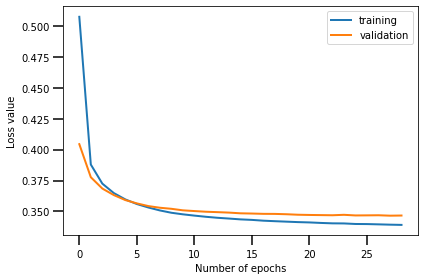

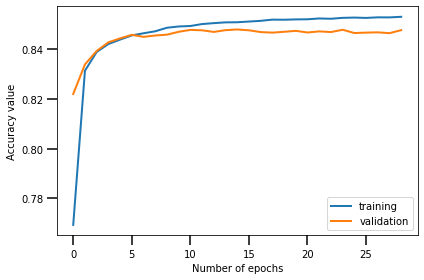

In [28]:
create_loss_plot(fit_history, "loss.png")
create_accuracy_plot(fit_history, "accuracy.png")

# Checking for bias

Since we would like to apply the NN to events used to trained the NN, we need to make sure that this will not result in bias. To do that we can plot the NN output for events in the training set as well as the up-to-now unused test set and check if there are difference.

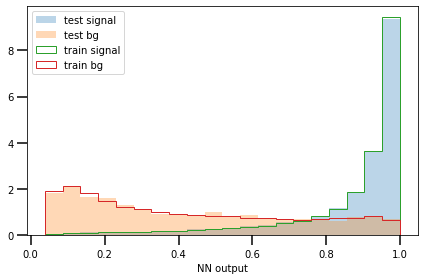

In [29]:
create_nn_output_plot(model, x_train, x_test, y_train, y_test, "nn_output.png")